In [142]:
import torch
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
from data_setup import CustomDataset
from metrics import accuracy_fn, EarlyStopping
from torch.utils.data import DataLoader
from sklearn.metrics import recall_score, precision_score, f1_score

In [143]:
class Positional_Encoding(torch.nn.Module):
    def __init__(self, seq_length, n_dim):
        super(Positional_Encoding, self).__init__()
        self.seq_length = seq_length
        self.n_dim = n_dim

    def forward(self):
        # positional vector
        position_encode = torch.zeros((self.seq_length, self.n_dim))
        for pos in range(self.seq_length):
            for i in range(0, self.n_dim, 2):
                position_encode[pos, i] = math.sin(pos / (10000 ** (2 * i / self.n_dim)))
                position_encode[pos, i+1] = math.cos(pos / (10000 ** (2 * i / self.n_dim)))
        return position_encode

class MultiHeadAttention(torch.nn.Module):
    def __init__(self, n_head, n_dim):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.n_dim = n_dim
        self.n_dim_each_head = int(self.n_dim / self.n_head)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # init query, key, value
        self.query_matrix = torch.nn.Linear(self.n_dim_each_head, self.n_dim_each_head, bias=False)
        self.key_matrix = torch.nn.Linear(self.n_dim_each_head, self.n_dim_each_head, bias=False)
        self.value_matrix = torch.nn.Linear(self.n_dim_each_head, self.n_dim_each_head, bias=False)
        self.output_matrix = torch.nn.Linear(self.n_dim_each_head * self.n_head, self.n_dim_each_head * self.n_head, bias=False)

    def forward(self, query, key, value, mask=None):  # (batch_size, seq_length, n_dim)
        batch_size = key.size(0)
        seq_length = key.size(1)
        seq_length_query = query.size(1)
        # divide head => (batch_size, seq_length, n_head, n_dim_each_head)
        query = query.view(batch_size, seq_length_query, self.n_head, self.n_dim_each_head)
        key = key.view(batch_size, seq_length, self.n_head, self.n_dim_each_head)
        value = value.view(batch_size, seq_length, self.n_head, self.n_dim_each_head)
        q = self.query_matrix(query)
        k = self.key_matrix(key)
        v = self.value_matrix(value)
        # transpose => (batch_size, n_head, seq_length, n_dim_each_head)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        # -------------------------- Compute MultiHead-Attention --------------------------
        """
        - Step 1: compute matmul(q, k^T)
        - Step 2: scale with sqrt(n_dim)
        - Step 3: compute softmax => matrix A
        - Step 4: compute matmul of matrix A and value matrix
        - Step 5: concatenate matrix => matrix Z
        - Step 4: compute matmul of matrix Z and matrix W0
        """
        k_T = k.transpose(-1, -2)  # => (batch_size, n_head, n_dim_each_head, seq_length)
        product = torch.matmul(q, k_T)  # => (batch_size, n_head, seq_length_query, seq_length)
        product = product / math.sqrt(self.n_dim_each_head)
        if mask is not None:
            product = product.masked_fill(mask == 0, float("-1e20"))
        product = product.to(self.device)
        scores = F.softmax(product, dim=-1)  # => (batch_size, n_head, seq_length_query, seq_length)
        scores = torch.matmul(scores, v)  # => (batch_size, n_head, seq_length_query, n_dim_each_head)
        scores = scores.transpose(1, 2)  # => (batch_size, seq_length_query, n_head, n_dim_each_head)
        scores = scores.contiguous().view(batch_size, seq_length_query, self.n_dim_each_head * self.n_head)
        output = self.output_matrix(scores)
        return output

class TransformerBlock(torch.nn.Module):
    def __init__(self, n_head, n_dim, n_expansion):
        super(TransformerBlock, self).__init__()
        # parameters
        self.n_head = n_head
        self.n_dim = n_dim
        self.n_expansion = n_expansion
        # instances
        self.multihead = MultiHeadAttention(n_head=self.n_head, n_dim=self.n_dim)
        self.norm_attention = torch.nn.LayerNorm(self.n_dim)
        self.feedforward = torch.nn.Sequential(
            torch.nn.Linear(self.n_dim, self.n_expansion * self.n_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(self.n_expansion * self.n_dim, self.n_dim),
            torch.nn.LeakyReLU(),
        )
        self.norm_feedforward = torch.nn.LayerNorm(self.n_dim)

    def forward(self, query, key, value):
        multihead_vector = self.multihead(query, key, value)
        add_norm_vector = self.norm_attention(multihead_vector + query)
        feed_forward_vector = self.feedforward(add_norm_vector)
        output = self.norm_feedforward(feed_forward_vector + add_norm_vector)
        return output

class ViT(torch.nn.Module):
    def __init__(self, input_chanel, output_chanel, n_head, n_expansion, n_layer, num_classes):
        super(ViT, self).__init__()
        # Parameters
        self.input_chanel = input_chanel
        self.output_chanel = output_chanel
        self.n_head = n_head
        self.n_expansion = n_expansion
        self.n_layer = n_layer
        self.num_classes = num_classes
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Instance
        self.patch_embedding = torch.nn.Sequential(
            torch.nn.Conv3d(in_channels=self.input_chanel, out_channels=32, kernel_size=(8, 32, 32), stride=(8, 32, 32), padding=(0, 0, 0)),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU(),
            torch.nn.Conv3d(in_channels=32, out_channels=self.output_chanel, kernel_size=(1, 7, 7), stride=(1, 7, 7), padding=(0, 0, 0)),
            torch.nn.BatchNorm3d(self.output_chanel),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Flatten(start_dim=-3),
        )
        self.transformer_block = TransformerBlock(self.n_head, self.output_chanel, self.n_expansion)
        self.dropout = torch.nn.Dropout(0.1)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(self.output_chanel, self.num_classes)
        )

    def add_cls_token(self, x):
        batch_size = x.shape[0]
        cls_token = torch.nn.Parameter(data=torch.zeros(batch_size, 1, self.output_chanel), requires_grad=True).to(self.device)
        return torch.concat([cls_token, x], dim=1)

    def forward(self, x):
        """ Input shape: (batch_size, chanel, height, width) """
        x = self.patch_embedding(x)     # => (batch_size, seq_len, output_chanel)
        x = x.transpose(-1, -2)
        x = self.add_cls_token(x)       # => (batch_size, seq_len+1, output_chanel)
        position = Positional_Encoding(seq_length=x.shape[1], n_dim=self.output_chanel)
        x = x + position().to(self.device)
        for _ in range(self.n_layer):
            x = self.transformer_block(x, x, x)
            x = self.dropout(x)
        x = x[:, 0, :]
        output = self.fc(x)
        return output


In [144]:
with open('label.txt', 'r') as f:
    classes = [line.rstrip() for line in f.readlines()]

In [145]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
""" Create dataloader """
root_path = 'processed_data/'
train_path = 'train_data.csv'
val_path = 'val_data.csv'
batch_size = 64
train_dataset = CustomDataset(root_path, train_path)
val_dataset = CustomDataset(root_path, val_path)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True)
class_weights = torch.load('class_weights.pt', map_location=device)

In [146]:
""" Create Model """
input_chanel = 3
output_chanel = 64
n_head = 2
n_expansion = 4
n_layer = 1
num_classes = len(classes)
model = ViT(input_chanel, output_chanel, n_head, n_expansion, n_layer, num_classes).to(device)

In [147]:
""" Create Metrics """
epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device))
early_stopping = EarlyStopping(patience=5, delta=0.01, verbose=True)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2)

""" Training model """
result = {
    'train_acc': [],
    'train_loss': [],
    'train_recall': [],
    'train_precision': [],
    'train_f1': [],
    'val_acc': [],
    'val_loss': [],
    'val_recall': [],
    'val_precision': [],
    'val_f1': [],
}

In [148]:
def compute_recall_precision(y_true, y_pred):
    y_pred = torch.argmax(y_pred, dim=-1)
    recall = recall_score(y_true.cpu().numpy(), y_pred.cpu().numpy(), average='macro', zero_division=0)
    precision = precision_score(y_true.cpu().numpy(), y_pred.cpu().numpy(), average='macro', zero_division=0)
    f1 = f1_score(y_true.cpu().numpy(), y_pred.cpu().numpy(), average='macro', zero_division=0)
    return recall, precision, f1

In [149]:
for epoch in range(epochs):
    torch.cuda.empty_cache()
    # ---------------------------------------- Training ----------------------------------------
    train_loss = 0
    train_acc = 0
    train_recall, train_precision, train_f1 = 0, 0, 0
    for batch, (X, y) in enumerate(train_loader):
        model.train()
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_acc += accuracy_fn(torch.softmax(y_pred, dim=1).argmax(dim=1), y)
        recall, precision, f1 = compute_recall_precision(y, y_pred)
        train_recall += recall
        train_precision += precision
        train_f1 += f1
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_recall /= len(train_loader)
    train_precision /= len(train_loader)
    train_f1 /= len(train_loader)
    # ---------------------------------------- Validation ----------------------------------------
    val_loss = 0
    val_acc = 0
    val_recall, val_precision, val_f1 = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(val_loader):
            X, y = X.to(device), y.to(device)
            # Forward pass
            y_pred = model(X)
            # Calculate validation loss and accuracy
            val_loss += criterion(y_pred, y).item()
            val_acc += accuracy_fn(torch.softmax(y_pred, dim=1).argmax(dim=1), y)
            recall, precision, f1 = compute_recall_precision(y, y_pred)
            val_recall += recall
            val_precision += precision
            val_f1 += f1
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    val_recall /= len(val_loader)
    val_precision /= len(val_loader)
    val_f1 /= len(val_loader)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.2f}, Train Acc: {train_acc:.2f}, Train Recall: {train_recall:.2f}, Train Precision: {train_precision:.2f}, Train F1: {train_f1:.2f},"
          f" Val Loss: {val_loss:.2f}, Val Acc: {val_acc:.2f}, Val Recall: {val_recall:.2f}, Val Precision: {val_precision:.2f}, Val F1: {val_f1:.2f} ")
    result['train_acc'].append(train_acc)
    result['train_loss'].append(train_loss)
    result['train_recall'].append(train_recall)
    result['train_precision'].append(train_precision)
    result['train_f1'].append(train_f1)
    
    result['val_acc'].append(val_acc)
    result['val_loss'].append(val_loss)
    result['val_recall'].append(val_recall)
    result['val_precision'].append(val_precision)
    result['val_f1'].append(val_f1)
    # ---------------------------------------- Learning rate Schedule ----------------------------------------
    lr_scheduler.step(val_loss)
    # ---------------------------------------- Check EarlyStopping ----------------------------------------
    if early_stopping(val_loss):
        break

Epoch 1: Train Loss: 2.86, Train Acc: 0.21, Train Recall: 0.21, Train Precision: 0.19, Train F1: 0.16, Val Loss: 2.44, Val Acc: 0.44, Val Recall: 0.39, Val Precision: 0.39, Val F1: 0.34 
Epoch 2: Train Loss: 1.72, Train Acc: 0.66, Train Recall: 0.63, Train Precision: 0.64, Train F1: 0.60, Val Loss: 1.22, Val Acc: 0.78, Val Recall: 0.74, Val Precision: 0.74, Val F1: 0.71 
Epoch 3: Train Loss: 0.83, Train Acc: 0.88, Train Recall: 0.87, Train Precision: 0.86, Train F1: 0.85, Val Loss: 0.75, Val Acc: 0.87, Val Recall: 0.88, Val Precision: 0.89, Val F1: 0.86 
Epoch 4: Train Loss: 0.44, Train Acc: 0.96, Train Recall: 0.96, Train Precision: 0.95, Train F1: 0.95, Val Loss: 0.42, Val Acc: 0.93, Val Recall: 0.92, Val Precision: 0.92, Val F1: 0.91 
Epoch 5: Train Loss: 0.26, Train Acc: 0.99, Train Recall: 0.98, Train Precision: 0.98, Train F1: 0.98, Val Loss: 0.29, Val Acc: 0.96, Val Recall: 0.95, Val Precision: 0.95, Val F1: 0.95 
Epoch 6: Train Loss: 0.16, Train Acc: 0.99, Train Recall: 0.99, T

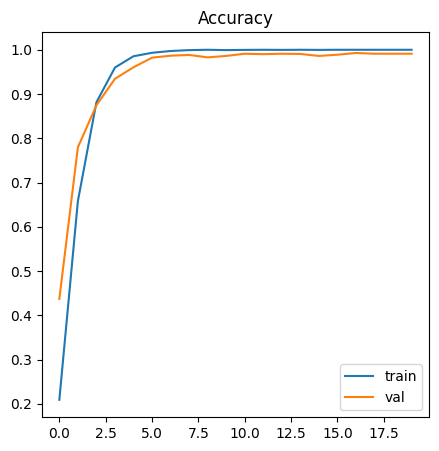

In [150]:
plt.figure(1, figsize=(5, 5))
plt.plot([i.cpu().detach().numpy() for i in result['train_acc']])
plt.plot([i.cpu().detach().numpy() for i in result['val_acc']])
plt.legend(['train', 'val'])
plt.title('Accuracy')
plt.show()

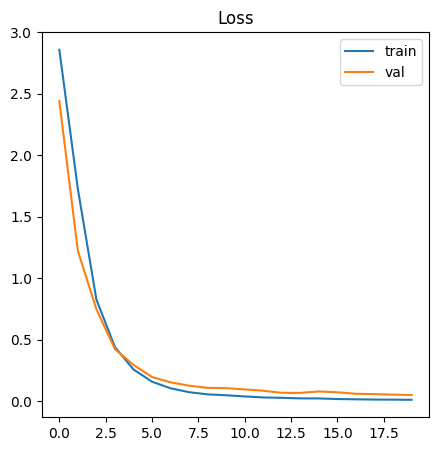

In [151]:
plt.figure(2, figsize=(5, 5))
plt.plot(result['train_loss'])
plt.plot(result['val_loss'])
plt.legend(['train', 'val'])
plt.title('Loss')
plt.show()

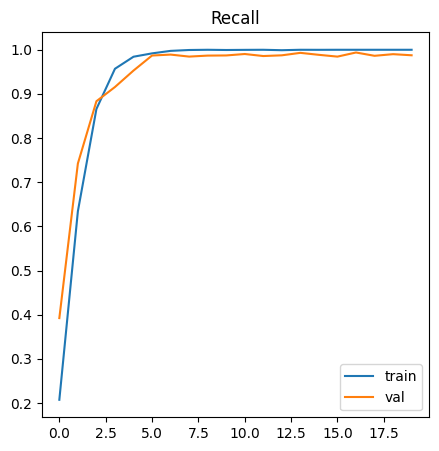

In [152]:
plt.figure(3, figsize=(5, 5))
plt.plot(result['train_recall'])
plt.plot(result['val_recall'])
plt.legend(['train', 'val'])
plt.title('Recall')
plt.show()

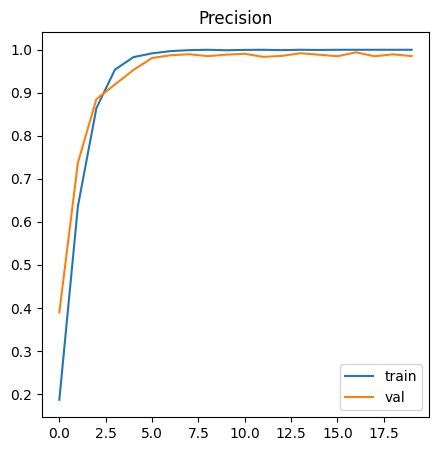

In [153]:
plt.figure(4, figsize=(5, 5))
plt.plot(result['train_precision'])
plt.plot(result['val_precision'])
plt.legend(['train', 'val'])
plt.title('Precision')
plt.show()

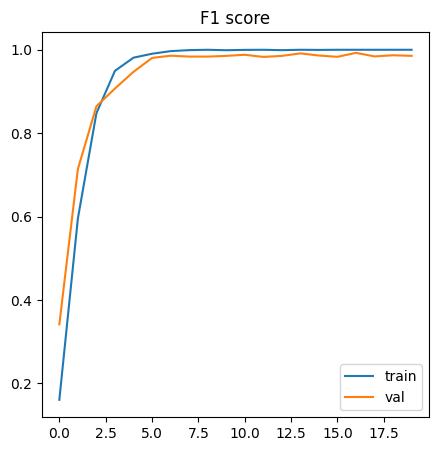

In [154]:
plt.figure(5, figsize=(5, 5))
plt.plot(result['train_f1'])
plt.plot(result['val_f1'])
plt.legend(['train', 'val'])
plt.title('F1 score')
plt.show()

In [155]:
torch.save({
    'model_state_dict': model.state_dict(),
    'class': classes
}, 'checkpoint_2.pth.tar')

In [167]:
import cv2
import os
import numpy as np
from torchvision.transforms import v2

def get_frames(video_path, num_frames):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    rate = 1
    frames = []
    if total_frames > 2 * num_frames:
        rate = int(total_frames / num_frames)
    idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if idx % rate == 0:
            frames.append(np.asarray(frame))
        idx += 1
        if len(frames) == num_frames:
            break
    while len(frames) != num_frames:
        frames.append(np.zeros_like(frames[-1]))
    return frames

image_size = (224, 224)
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(image_size, antialias=True),
    v2.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
num_frames = 48
video_path = "Test - Vòng loại-20240324T141643Z-001/Test - Vòng loại/chest fly machine_3.mp4"
for dir in os.listdir("Test - Vòng loại-20240324T141643Z-001/Test - Vòng loại"):
    video_path = os.path.join("Test - Vòng loại-20240324T141643Z-001/Test - Vòng loại", dir)
    frames = get_frames(video_path, num_frames)
    tensors = []
    for frame in frames:
        tensor = transform(frame)
        tensor = torch.unsqueeze(tensor, dim=0)
        tensors.append(tensor)
    input_video = torch.concatenate(tensors, dim=0)
    input_video = input_video.transpose(0, 1)
    with torch.no_grad():
        model.eval()
        x = torch.unsqueeze(input_video, 0).to(device)
        y = model(x)
        
    idx = torch.argmax(y, -1).item()
    print(dir, "------", classes[idx])

barbell biceps curl_1.mp4 ------ russian twist
bench press_1.mp4 ------ bench press
bench press_2.mp4 ------ bench press
chest fly machine_1.mp4 ------ chest fly machine
chest fly machine_2.mp4 ------ chest fly machine
chest fly machine_3.mp4 ------ chest fly machine
deadlift_1.mp4 ------ deadlift
declince bench press_1.mp4 ------ decline bench press
decline bench press_2.mp4 ------ decline bench press
hammer curl_1.mp4 ------ hammer curl
hammer curl_2.mp4 ------ hammer curl
hip thrush_1.mp4 ------ hip thrust
hip thrust_1.mp4 ------ hip thrust
incline bench press_1.mp4 ------ incline bench press
incline bench press_2.mp4 ------ incline bench press
lat pulldown_1.mp4 ------ lat pulldown
lat pulldown_2.mp4 ------ lat pulldown
lateral raise_1.mp4 ------ lateral raise
leg extension_1.mp4 ------ leg extension
leg extension_2.mp4 ------ leg extension
leg raises_1.mp4 ------ leg raises
leg raises_2.mp4 ------ leg raises
plank_1.mp4 ------ push-up
pull up_1.mp4 ------ pull Up
pull up_2.mp4 ---